In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [10]:
prob = "LunarLander"
window_size = 10


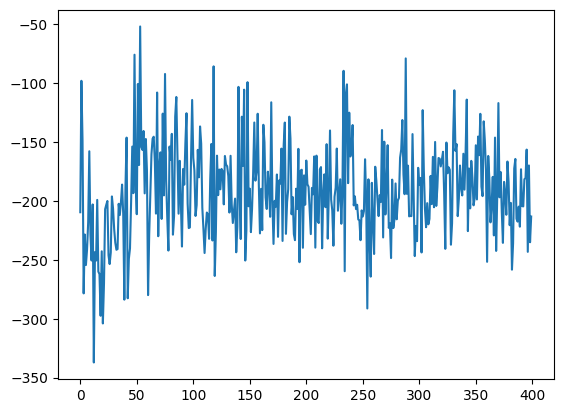

In [4]:
plt.plot(np.load("C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\LunarLander_MPC_QRNN_basic_mid_LowerYGoal_May6.npz")['mean_rewards'])


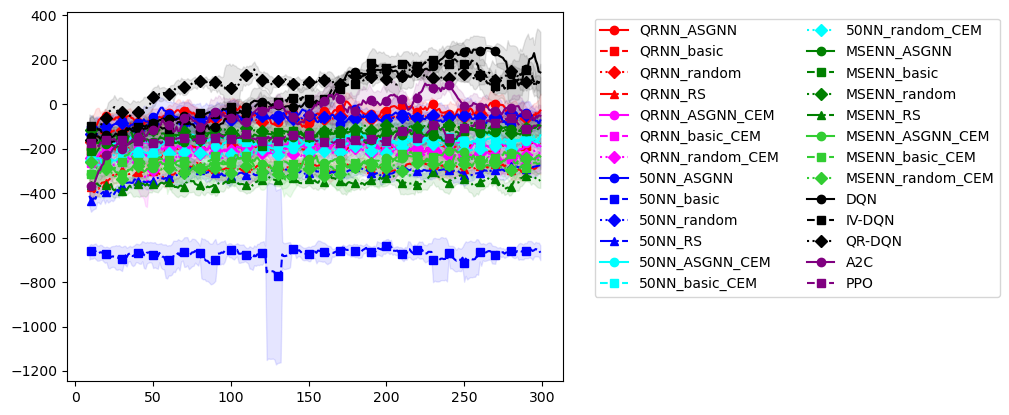

In [11]:
QRNN = {'QRNN_ASGNN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_ASGNN_mid_May6.npz',
    'QRNN_basic': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_basic_mid_May6.npz',
    'QRNN_random': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_random_mid_May6.npz',
    'QRNN_RS': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_RS_mid_QRNN_May6.npz',}
color = 'red'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in QRNN.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

QRNN_CEM = {'QRNN_ASGNN_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_ASGNN_mid_May6_CEM.npz',
    'QRNN_basic_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_basic_mid_May6_CEM.npz',
    'QRNN_random_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_random_mid_May6_CEM.npz',}
color = 'magenta'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in QRNN_CEM.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ####################################################
FiftyNN = {'50NN_ASGNN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_ASGNN_mid_May6.npz',
    '50NN_basic': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_basic_mid_May6.npz',
    '50NN_random': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_random_mid_May6.npz',
    '50NN_RS': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_RS_mid_50NN_May6.npz',}
color = 'blue'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in FiftyNN.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

FiftyNN_CEM = {'50NN_ASGNN_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_ASGNN_mid_May6_CEM.npz',
    '50NN_basic_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_basic_mid_May6_CEM.npz',
    '50NN_random_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_random_mid_May6_CEM.npz',}
color = 'aqua'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in FiftyNN_CEM.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# ####################################################
MSENN = {'MSENN_ASGNN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_MSENN_ASGNN_mid_May6.npz',
    'MSENN_basic': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_MSENN_basic_mid_May6.npz',
    'MSENN_random': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_MSENN_random_mid_May6.npz',
    'MSENN_RS': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_RS_mid_MSENN_May6.npz',}
color = 'green'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in MSENN.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

MSENN_CEM = {'MSENN_ASGNN_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_MSENN_ASGNN_mid_May6_CEM.npz',
    'MSENN_basic_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_MSENN_basic_mid_May6_CEM.npz',
    'MSENN_random_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_MSENN_random_mid_May6_CEM.npz',}
color = 'limegreen'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in MSENN_CEM.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ####################################################
# DQN_methods = {'DQN': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_DQN_results.npz',
#     'IV-DQN': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_IV_DQN_results.npz',
#     'QR-DQN': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_QR_DQN_results.npz',
#     }
DQN_methods = {'DQN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_DQN_results.npz',
    'IV-DQN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_IV_DQN_results.npz',
    'QR-DQN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_QR_DQN_results.npz',
    }

color = 'black'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in DQN_methods.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


########################
RL_methods = {'A2C': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_A2C_results.npz',
    'PPO': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_PPO_results.npz',
    # 'DDPG': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_DDPG_results.npz',
    # 'SAC': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_SAC_results.npz',
    # 'TD3': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_TD3_results.npz',
    # 'TQC': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_TQC_results.npz',
    
    # 'A2C': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_A2C_results.npz',
    # 'DDPG': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_DDPG_results.npz',
    # 'PPO': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_PPO_results.npz',
    # 'SAC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_SAC_results.npz',
    # 'TD3': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TD3_results.npz',
    # 'TQC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TQC_results.npz',
    }

color = 'purple'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', ' ', '', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in RL_methods.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',ncol=2)

# ########################
# RL_methods = {# 'A2C': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\CartPole_A2C_results.npz',
#     'A2C': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_A2C_results.npz',
#     'PPO': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_PPO_results.npz',
#     # # 'PPO': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\CartPole_PPO_results.npz',
#     # 'A2C': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_A2C_results.npz',
#     # # 'DDPG': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_DDPG_results.npz',
#     # 'PPO': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_PPO_results.npz',
#     # # 'SAC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_SAC_results.npz',
#     # # 'TD3': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TD3_results.npz',
#     # # 'TQC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TQC_results.npz',
#     }

# A2C_data = np.load(RL_methods['A2C'])
# mean_returns_A2C = A2C_data['mean_rewards'][:300]
# std_returns_A2C = A2C_data['std_rewards'][:300]
# # Smooth the data
# smoothed_mean_A2C = pd.Series(mean_returns_A2C).rolling(window=window_size).mean()
# smoothed_std_A2C = pd.Series(std_returns_A2C).rolling(window=window_size).std()

# PPO_data = np.load(RL_methods['PPO'])
# mean_returns_PPO = PPO_data['mean_rewards'][:300]
# std_returns_PPO = PPO_data['std_rewards'][:300]
# # Smooth the data
# smoothed_mean_PPO = pd.Series(mean_returns_PPO).rolling(window=window_size).mean()
# smoothed_std_PPO = pd.Series(std_returns_PPO).rolling(window=window_size).std()

# plt.plot(smoothed_mean_A2C, label='A2C', color='purple')
# plt.fill_between(range(len(smoothed_mean_A2C)), 
#                  smoothed_mean_A2C - smoothed_std_A2C, 
#                  smoothed_mean_A2C + smoothed_std_A2C, 
#                  color='purple', alpha=0.1)
# plt.plot(smoothed_mean_PPO, label='PPO', color='Olive')
# plt.fill_between(range(len(smoothed_mean_PPO)), 
#                  smoothed_mean_PPO - smoothed_std_PPO, 
#                  smoothed_mean_PPO + smoothed_std_PPO, 
#                  color='Olive', alpha=0.1)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',ncol=2)
